In [36]:
from models import SRCNN
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
from torchvision.transforms import functional as F
from io import BytesIO
import PIL.Image
from IPython.display import Image, clear_output, display


import torch
import torch.hub
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models, datasets, transforms



In [24]:
def showarray(a, fmt='jpeg'):
    ''' Helper function. Use this to show your filters

    Converting to standard image format is a common task that produces garbage
    images when not done correctly. We've provided the correct conversions'''
    a = np.uint8(np.clip(a, 0, 255))
    f = BytesIO()
    PIL.Image.fromarray(a).save(f, fmt)
    display(Image(data=f.getvalue()))


def normalize_tensor(tensor):
    # TODO (1a): Normalize between 0 and 255, format as np.uint8
    ans = np.uint8(np.round((tensor - tensor.min())* 255 / (tensor.max()-tensor.min())))

    print(ans.min(), ans.max()) #should be 0 and 255

    return ans


In [25]:
device = torch.device("mps")

In [26]:
model = SRCNN()
model.load_state_dict(torch.load("pretrained/srcnn_x4.pth", map_location=device))
model.to(device)
model.eval()

SRCNN(
  (conv1): Conv2d(1, 64, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
  (conv2): Conv2d(64, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv3): Conv2d(32, 1, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu): ReLU(inplace=True)
)

In [62]:
submodules=list(model.children())

In [28]:
hr_image_path = '../../Datasets/Set14/Set14_HR/comic.png'
hr_image = cv2.imread(hr_image_path, cv2.IMREAD_COLOR)

lr_image_path = '../../Datasets/Set14/Set14_LR_x4/comic.png'
lr_image = cv2.imread(lr_image_path, cv2.IMREAD_COLOR)


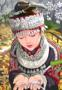

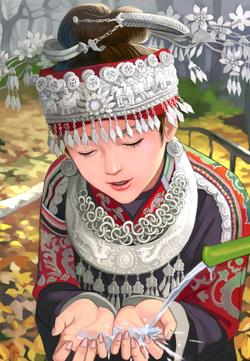

In [127]:
lr_img_pil = PIL.Image.open(lr_image_path).convert('RGB')
lr_img_numpy = np.array(lr_img_pil)
showarray(lr_img_numpy)

hr_img_pil = PIL.Image.open(hr_image_path).convert('RGB')
hr_img_numpy = np.array(hr_img_pil)
showarray(hr_img_numpy)

In [131]:
center_crop = transforms.Compose(
    [
        transforms.Resize((227, 227)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]
)

# our model can only take input that is preprocessed, so preprocess our loaded image
lr_img_tensor = center_crop(lr_img_pil).to(device)
hr_img_tensor = center_crop(hr_img_pil).to(device)

In [132]:
lr_img_tensor.shape

torch.Size([3, 227, 227])

In [133]:
hr_img_tensor.shape

torch.Size([3, 227, 227])

In [75]:


res=model(img_tensor.unsqueeze(0).transpose(0,1))

In [65]:
len(submodules)

4

In [134]:
def features(img_tensor, model):
    submodules=list(model.children())
    features=[]
    last = img_tensor.unsqueeze(0).transpose(0,1).to(device)
    for submodule in submodules:
        last = submodule(last)
        features.append(last)
    return features

def featureLoss(img_tensor_1, img_tensor_2, model):
    features_1 = features(img_tensor_1, model)
    features_2 = features(img_tensor_2,model)

    feature_loss=[]
    for i in range(len(features_1)):
        scale = 1 / np.prod(features_1[i].shape)
        feature_loss.append(scale * torch.norm(features_1[i] - features_2[i]))
    return(torch.tensor(feature_loss).to(device))
        
    
    
    

In [140]:
model(lr_img_tensor.unsqueeze(0).transpose(0,1)).shape

torch.Size([3, 1, 227, 227])

In [136]:
featureLoss(lr_img_tensor, hr_img_tensor, model)

tensor([0.0001, 0.0010, 0.0067, 0.0067], device='mps:0')

In [112]:
np.prod(features(img_tensor, model)[3].shape)

16740

In [73]:
features[3]

tensor([[[[2.2482e+00, 1.6326e+00, 0.0000e+00,  ..., 3.7138e+00,
           2.9573e+00, 1.3870e+00],
          [3.7052e+00, 3.4889e+00, 3.2829e-02,  ..., 4.4437e+00,
           3.5719e+00, 1.1375e+00],
          [4.3304e+00, 3.8068e+00, 0.0000e+00,  ..., 1.5873e+00,
           1.3873e+00, 0.0000e+00],
          ...,
          [9.1708e+00, 4.4776e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [1.1209e+01, 8.8090e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 1.1468e+00],
          [8.8583e+00, 8.1134e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 1.7040e+00]]],


        [[[2.9017e+00, 2.0689e+00, 0.0000e+00,  ..., 4.8291e+00,
           3.9291e+00, 1.8894e+00],
          [4.7398e+00, 4.4602e+00, 1.0416e-02,  ..., 5.7807e+00,
           5.0305e+00, 1.8288e+00],
          [5.4865e+00, 4.8847e+00, 0.0000e+00,  ..., 2.1746e+00,
           2.6266e+00, 0.0000e+00],
          ...,
          [3.9193e+00, 1.1588e+00, 0.0000e+00,  ..., 0.00

In [59]:
res.shape

torch.Size([3, 1, 227, 227])

In [60]:
img_tensor.shape

torch.Size([3, 227, 227])

In [52]:
img_tensor.unsqueeze(0).transpose(0,1).shape

torch.Size([3, 1, 9, 9])

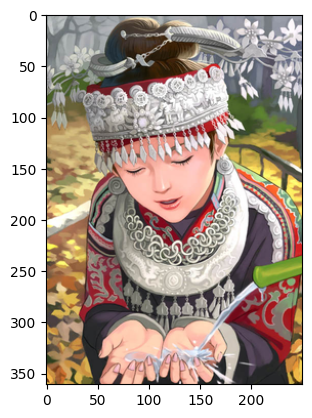

In [52]:
im = hr_image
rgb = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
plt.imshow(rgb, cmap = plt.cm.Spectral)


plt.imshow(rgb)

In [14]:
def bgr2ycbcr(image: np.ndarray, only_use_y_channel: bool) -> np.ndarray:
    """Implementation of bgr2ycbcr function in Matlab under Python language.

    Args:
        image (np.ndarray): Image input in BGR format
        only_use_y_channel (bool): Extract Y channel separately

    Returns:
        image (np.ndarray): YCbCr image array data

    """
    if only_use_y_channel:
        image = np.dot(image, [24.966, 128.553, 65.481]) + 16.0
    else:
        image = np.matmul(image, [[24.966, 112.0, -18.214], [128.553, -74.203, -93.786], [65.481, -37.797, 112.0]]) + [
            16, 128, 128]

    image /= 255.
    image = image.astype(np.float32)

    return image


In [15]:
lr_y_image =  bgr2ycbcr(lr_image, True)
lr_y_tensor = F.to_tensor(lr_y_image).unsqueeze_(0).to(device)

sr_y_tensor = model(lr_y_tensor).clamp_(0, 1.0)


In [16]:
sr_y_tensor

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/_tensor_str.py:137: UserWarning: MPS: nonzero op is supported natively starting from macOS 13.0. Falling back on CPU. This may have performance implications. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/mps/operations/Indexing.mm:283.)
  nonzero_finite_vals = torch.masked_select(


tensor([[[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]]]], device='mps:0',
       grad_fn=<ClampBackward1>)

In [67]:
sr_y_image = imgproc.tensor2image(sr_y_tensor, False, False)
sr_y_image = sr_y_image.astype(np.float32) / 255.0
#sr_ycbcr_image = cv2.merge([sr_y_image, lr_cb_image, lr_cr_image])
#sr_image = imgproc.ycbcr2bgr(sr_ycbcr_image)

AttributeError: module 'imgproc' has no attribute 'tensor2image'

In [71]:
sr_y_image = imgproc.tensor2image(sr_y_tensor, False, False)
sr_y_image = sr_y_image.astype(np.float32) / 255.0
sr_ycbcr_image = cv2.merge([sr_y_image, lr_cb_image, lr_cr_image])
sr_image = imgproc.ycbcr2bgr(sr_ycbcr_image)

AttributeError: module 'imgproc' has no attribute 'tensor2image'

In [77]:
imgproc

<module 'imgproc' from '/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/imgproc/__init__.py'>

In [78]:
SRCNN

models.SRCNN